In [1]:
import os
import re

import numpy as np

import h5py

# for reading DR12Q.fits file
from astropy.io import fits

In [2]:
# plotting styles; making the inline plots resolution high enough
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi']= 150

In [3]:
# comment out this line if you are not at the notebooks/ folder
os.chdir("../")

In [4]:
from tests.test_zestimation import *

# Plotting the histogram of redshift estimation errors

For the histogram, we plot a batch of spectra's redshift estimations compared with the Z_VI values.

For z_map (GP's prediction), we would just use the archive version of GP zestimation catalog, which you can find in the shared drive http://tiny.cc/gp_zestimation_catalogue (`processed_zqso_only_qsos_dr12q-100.mat`).

In [5]:
# path to dr12q fits file

dr12q_fits = "data/dr12q/distfiles/DR12Q.fits"
gp_catalog = "data/dr12q/processed/processed_zqso_only_qsos_dr12q-100.mat"

gp_table = h5py.File(gp_catalog, "r")

Number of Quasars in Comparison:  158560


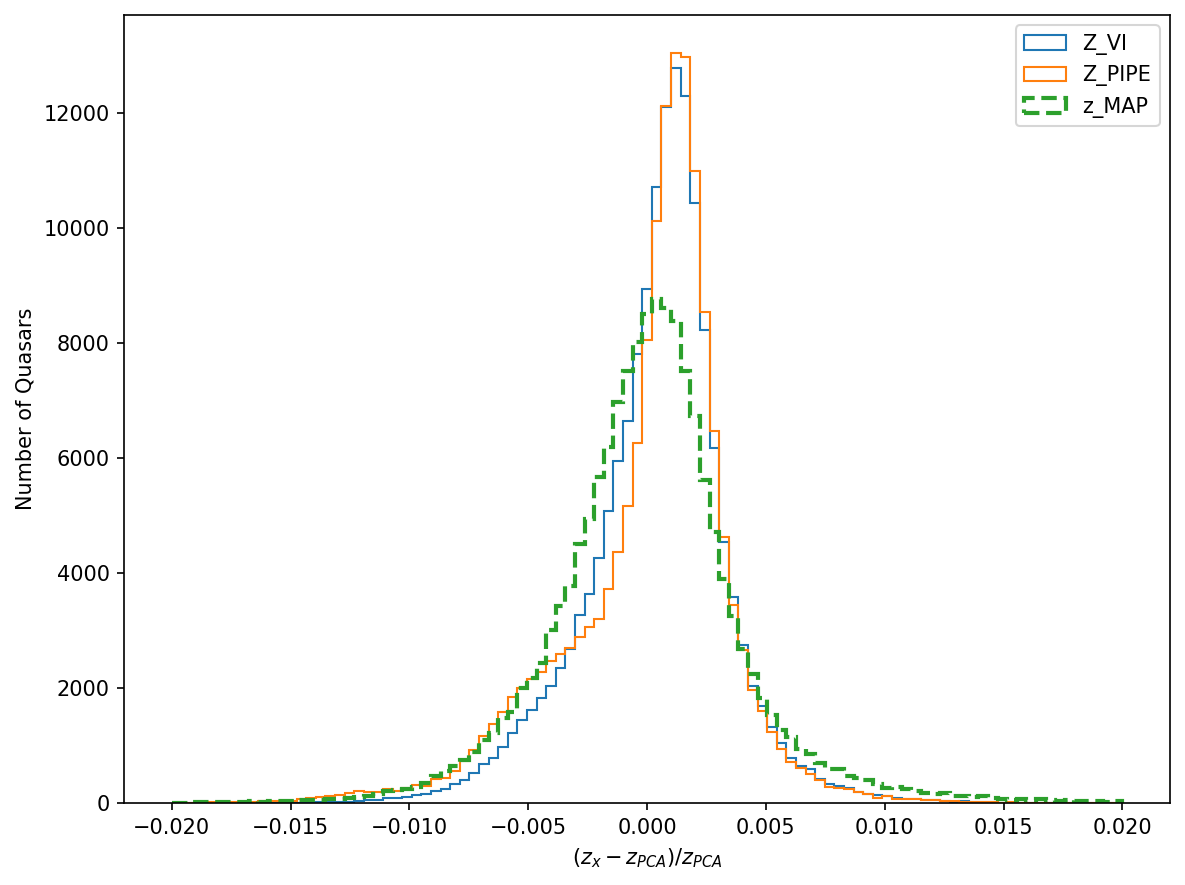

In [6]:
'''
Reproduce the figure 7 in SDSS DR12Q paper, with Z_MAP
'''

dr12q = fits.open(dr12q_fits)

# acquire the table data in SDSS DR12Q paper; Table 4.
table = dr12q[1].data

Z_VI   = table['Z_VI']
Z_PIPE = table['Z_PIPE']
Z_PCA  = table['Z_PCA']

# filter out non-detections in DR12Q.fits (were labeled as -1)
ind = [ Z != -1 for Z in (Z_VI, Z_PIPE, Z_PCA) ]
ind = np.all(ind, axis=0)


# get the ind for spectra processed in our GP catalog (archived version, processed_zqso_only_qsos_dr12q-100.mat)
test_ind = gp_table["test_ind"][0, :].astype(np.bool)
z_map_ind = ind[test_ind] # these are the indices for spectra processed in the archive version of the catalog

# we only compare the spectra both in our GP catalog and without non-detections in any
# of the redshift estimation methods in DR12Q.fits
ind = ind & test_ind

Z_VI   = Z_VI[ind]
Z_PIPE = Z_PIPE[ind]
Z_PCA  = Z_PCA[ind]

# z_map: the maximum a posteriori estimation of the GP method
z_map = gp_table["z_map"][0, :]
z_map = z_map[z_map_ind]

print("Number of Quasars in Comparison: ", z_map.shape[0])

bins = np.linspace(-0.02, 0.02, 100)

plt.figure(figsize=(8, 6))
plt.hist( (Z_VI   - Z_PCA) / Z_PCA, bins=bins, histtype='step', label='Z_VI')
plt.hist( (Z_PIPE - Z_PCA) / Z_PCA, bins=bins, histtype='step', label='Z_PIPE')
plt.hist( (z_map  - Z_PCA) / Z_PCA, bins=bins, histtype='step', label='z_MAP', ls="--", lw=2)
plt.xlabel('$(z_x - z_{PCA}) / z_{PCA}$')
plt.ylabel('Number of Quasars')
plt.legend()
plt.tight_layout()

Now we only consider quasars with Z_VI < 2.5

Number of Quasars in Comparison:  158560


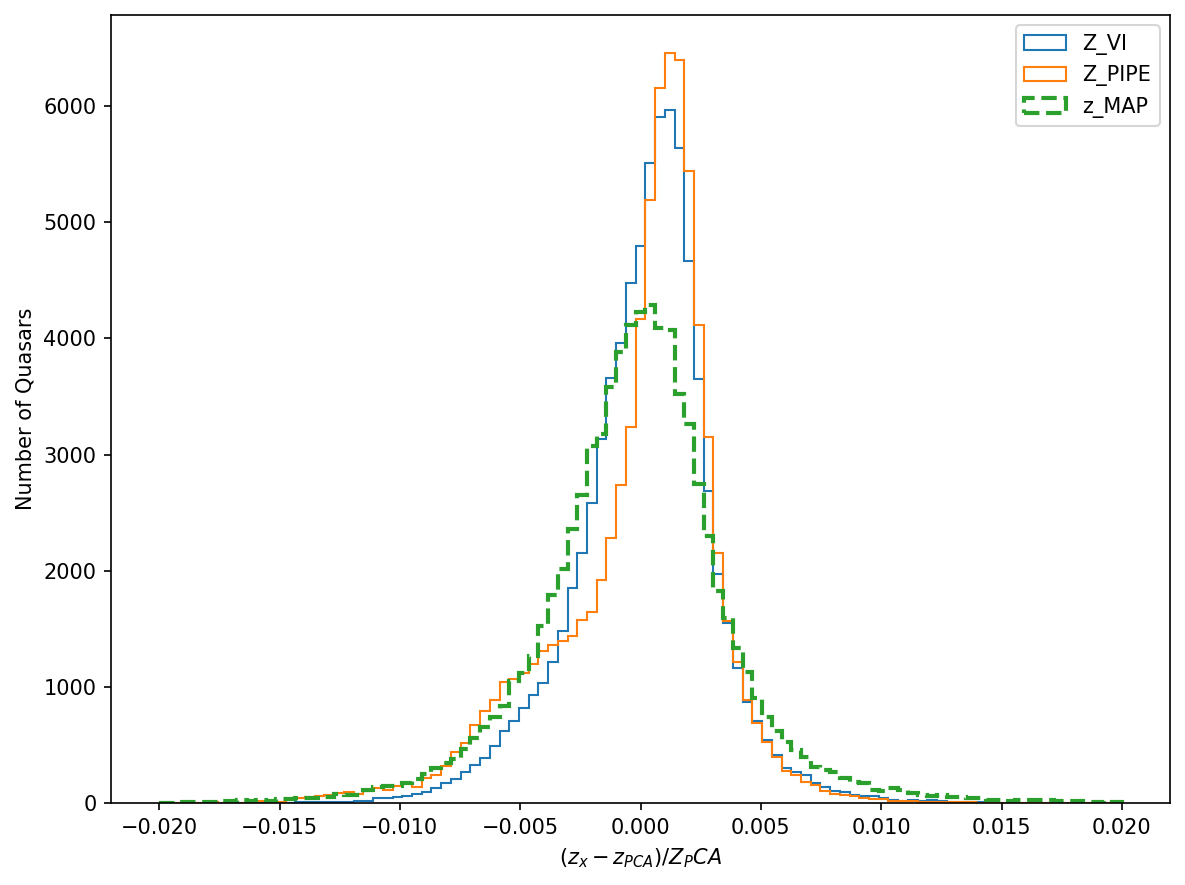

In [7]:
z_ind = Z_PCA < 2.5 # MODIFY THIS LINE 

print("Number of Quasars in Comparison: ", z_map.shape[0])

bins = np.linspace(-0.02, 0.02, 100)

plt.figure(figsize=(8, 6))
plt.hist( ((Z_VI   - Z_PCA) / Z_PCA)[z_ind], bins=bins, histtype='step', label='Z_VI')
plt.hist( ((Z_PIPE - Z_PCA) / Z_PCA)[z_ind], bins=bins, histtype='step', label='Z_PIPE')
plt.hist( ((z_map  - Z_PCA) / Z_PCA)[z_ind], bins=bins, histtype='step', label='z_MAP', ls="--", lw=2)
plt.xlabel('$(z_x - z_{PCA}) / Z_PCA$')
plt.ylabel('Number of Quasars')
plt.legend()
plt.tight_layout()

## Posterior probability distribution for an individual spectrum

In [8]:
# get an individual spectrum with redshift > 4
Z_VI   = table['Z_VI']

ind = Z_VI > 4 # MODIFY THIS LINE IF YOU WANT A DIFFERENT REDSHIFT RANGE

PLATE = table['PLATE']
MJD = table['MJD']
FIBERID = table["FIBERID"]

In [9]:
real_index = np.where(ind)[0]

print("Total number of spectrum with Z_VI > 4:", len(real_index))

real_index

Total number of spectrum with Z_VI > 4: 1876


array([   185,    228,    411, ..., 296528, 296745, 296914])

In [10]:
# Model setup: read a spectrum, setup GP model
# ----
# read a spectrum from SDSS DR12


# choose the first spectrum in real_index as an example
mspec = 185 # MODIFT THIS LINE TO GET A DIFFERENT SPECTRUM

plate = PLATE[mspec]
mjd = MJD[mspec]
fiber_id = FIBERID[mspec]

# true redshift (assume Z_VI is the true value)
z_true = Z_VI[mspec]

# path to the learned GP model (note: you might have a different path)
learned_file = "data/dr12q/processed/learned_zqso_only_model_outdata_full_dr9q_minus_concordance_norm_1176-1256.mat"

# filenames is an array for a list of spectra, and we take one of them here
filename = "spec-{:04d}-{:05d}-{:04d}.fits".format(plate, mjd, fiber_id)

# If we haven't downloaded the file, this cell will help you download the file from SDSS database
if not os.path.exists(filename):
    plate, mjd, fiber_id = re.findall(
        r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits", filename,
    )[0]
    retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

# make sure the file exists
assert os.path.exists(filename) == True

# read the raw spectrum
wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

# Initialize the model parameters
params = ZParameters()
z_qso_samples = ZSamples(params)

# load the model
z_qso_gp = ZGPMAT(
    params,
    z_qso_samples,
    learned_file=learned_file,
)

In [11]:
# Baseline model: normalizing with median of the Lyman peak
# ----
# 10,000 test redshifts, from 4 ~ 7, linearly spacing
test_redshifts = np.linspace(4, 7, 10000) # MODIFT THIS LINE IF YOU WANT A DIFFERENT SAMPLING RANGE

sample_log_likelihoods = []

# loop over all of the test redshift, fit the GP to the data, get the likelihood value
for i, z_qso in enumerate(test_redshifts):
    # [fit the GP to the data] set the data and interpolate the model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z_qso,
        normalize=True, # default normalization is the median flux of [1176A, 1256A] at rest-frame 
        build_model=True,
    )
    
    # [get the likelihood value]
    sample_log_likelihoods.append(z_qso_gp.log_model_evidence())

# find the redshift gives the highest likelihood
idx = np.argmax(sample_log_likelihoods) # MODIFY THIS LINE IF YOU WANT A DIFFERENT WAY TO GET Z_PRED
# the predicted redhisft is the redshift gives the highest likelihood
z_pred = test_redshifts[idx]
print(z_pred)

4.167716771677168


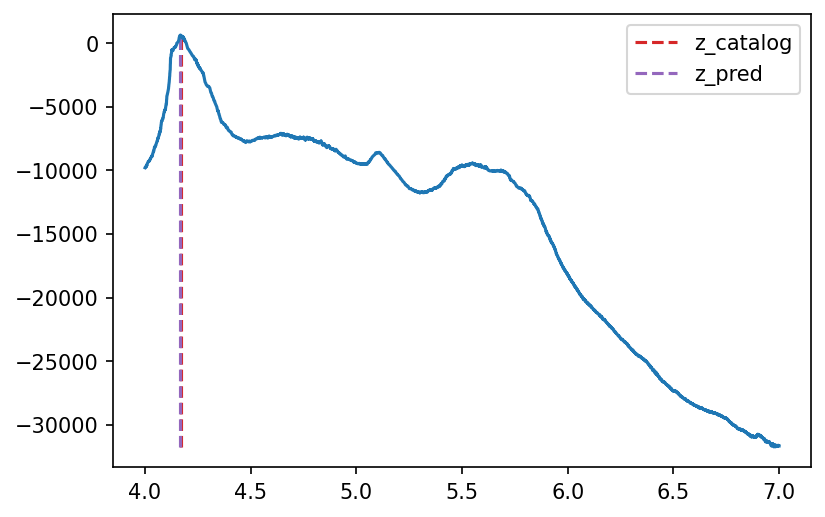

In [12]:
# plot the likelihood curve, inclding the locations of GP prediction and the true catalog values
plt.plot(test_redshifts, sample_log_likelihoods)
plt.vlines(z_true, min(sample_log_likelihoods) - 1, max(sample_log_likelihoods) + 1, ls='--', color="C3", label="z_catalog")
plt.vlines(z_pred, min(sample_log_likelihoods) - 1, max(sample_log_likelihoods) + 1, ls='--', color="C4", label="z_pred")
plt.legend()